In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import yfinance as yf
import datetime as dt


#from data_handler import get_sp500_ticker_list
from data_handler import get_adj_close
#from data_handler import sp500_closes_to_csv

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from scipy import stats
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from scipy.stats import probplot, moment
from sklearn.svm import SVR
from scipy.stats import uniform as sp_rand
from sklearn.model_selection import RandomizedSearchCV

In [2]:
# Setting some default layout options for plots
sns.set_style("whitegrid")
sns.mpl.rc("figure", figsize=(16, 6))
sns.mpl.rc("font", size=14)

# Getting the data

In [3]:
start='2018-01-01'
end='2020-12-31'
interval='1d'
ticker_list = ['AAPL', 'NVDA', 'FTNT']

df = get_adj_close(ticker_list, start, end, interval)

[*********************100%***********************]  3 of 3 completed


In [4]:
df.head()

,AAPL,FTNT,NVDA
Date,,,
2018-01-02,41.075397,44.349998,49.372391
2018-01-03,41.068256,45.029999,52.621780
2018-01-04,41.259014,44.000000,52.899155
2018-01-05,41.728756,44.099998,53.347443
2018-01-08,41.573761,45.000000,54.982040


# Analyze data

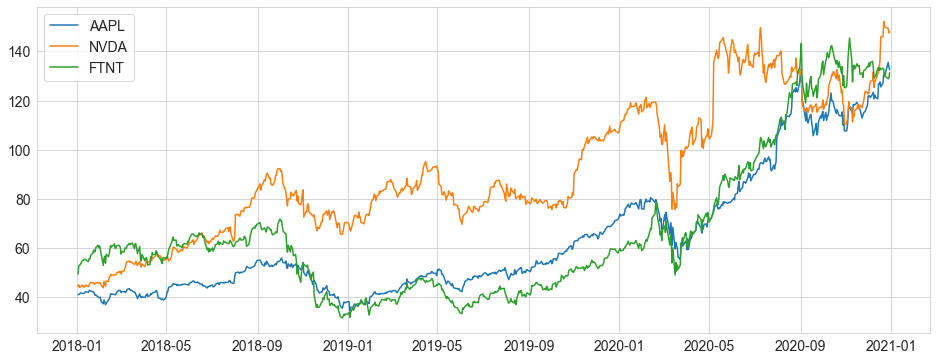

In [5]:
#plotting adjusted close price
plt.plot(df)
plt.legend(ticker_list)
plt.show()

In [6]:
#Computing the daily returns
returns = (df.pct_change())*100
returns.dropna(axis=0,inplace=True)
print(returns)

                AAPL      FTNT      NVDA
Date                                    
2018-01-03 -0.017385  1.533259  6.581390
2018-01-04  0.464490 -2.287361  0.527109
2018-01-05  1.138519  0.227269  0.847439
2018-01-08 -0.371434  2.040820  3.064060
2018-01-09 -0.011488 -1.511112 -0.027024
...              ...       ...       ...
2020-12-23 -0.697620 -1.255333 -2.025869
2020-12-24  0.771231 -0.299529 -0.119140
2020-12-28  3.576582 -0.333801 -0.721513
2020-12-29 -1.331500 -1.178910  0.335274
2020-12-30 -0.852655  0.332140  1.564522

[754 rows x 3 columns]


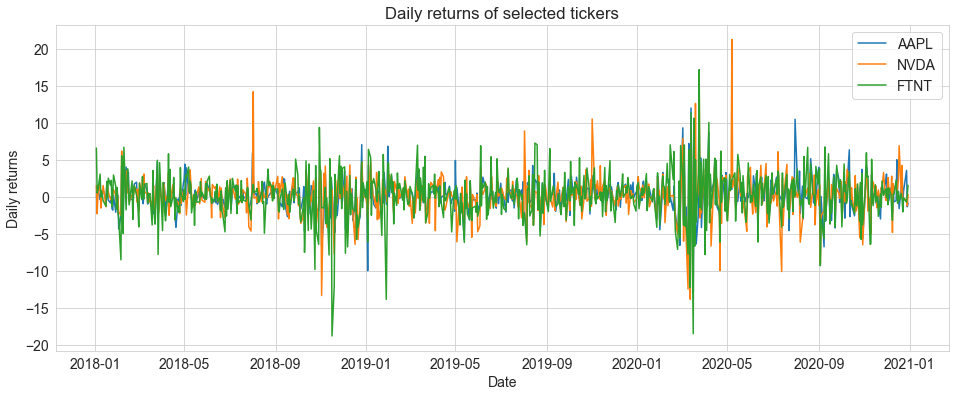

In [7]:
#plotting the returns
plt.plot(returns)
plt.title('Daily returns of selected tickers')
plt.ylabel('Daily returns')
plt.xlabel('Date')
plt.legend(ticker_list)
plt.show()

C:\Users\antoi\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


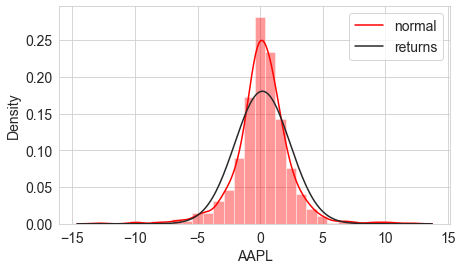

In [8]:
#plotting histograms to inspect distribution of the returns. We can clearly see fatter tails
plt.figure(figsize=(7,4))
sns.distplot(returns['AAPL'], norm_hist=True, fit=stats.norm, bins=30, color='r')
plt.legend(('normal', 'returns'))
plt.show()

In [9]:
def hurst(ts):
    """Returns the Hurst Exponent of the time series vector ts"""
    # Create the range of lag values
    lags = range(2, 100)
    
    # Calculate the array of the variances of the lagged differences
    tau = [np.sqrt(np.std(np.subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    
    # Use a linear fit to estimate the Hurst Exponent
    poly = np.polyfit(np.log(lags), np.log(tau), 1)
    
    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0

In [10]:
def plot_correlogram(x, lags=None, title=None):    
    lags = min(10, int(len(x)/5)) if lags is None else lags
    
    #plots layout
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
    
    x.plot(ax=axes[0][0])
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f} \nHurst: {round(hurst(x.values),2)}'
    
    #adding stats on top-left plot
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    
    #plotting qqplot
    probplot(x, plot=axes[0][1])
    
    #calculating distributions moments
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\n
        SD: {np.sqrt(var):>16.2f}\n
        Skew: {skew:12.2f}\n
        Kurtosis:{kurtosis:9.2f}'
    
    #adding stats on top-right plot
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    
    #plot autocorrelation
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    axes[1][0].set_xlabel('Lag')
    
    #plot autocorrelation function
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][1].set_xlabel('Lag')
    
    fig.suptitle(title, fontsize=20)
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

C:\Users\antoi\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


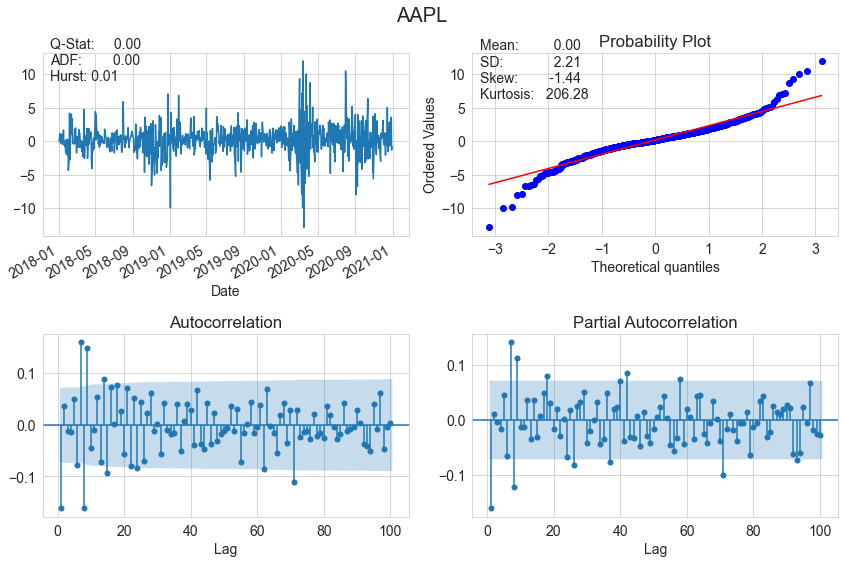

In [11]:
plot_correlogram(returns['AAPL'],lags=100, title="AAPL")

In [12]:
#Creating train and test sets (not the best way to proceed...)
#train_aapl = df.loc["2018-01-01":"2020-11-30","AAPL"]
#test_aapl = df.loc["2020-12-01":"2020-12-31","AAPL"]
#test_aapl

In [13]:
split_date = dt.datetime(2020,12,1)

# Modelling volatility with GARCH

In [14]:
#finding the best parameters
aic_garch = []

for p in range(1, 11): 
    for q in range(1,11):
        garch = arch_model(returns['AAPL'], mean='zero', vol='GARCH', p=p, q=q)\
            .fit(disp='off') 
        aic_garch.append(garch.aic) 
    
        if garch.aic == np.min(aic_garch): 
            best_param = (p,q) 
print(best_param) 

(3, 3)


In [15]:
#fitting the GARCH model on the train data set
garch = arch_model(returns['AAPL'], mean='zero', vol='GARCH', p=best_param[0], q=best_param[1])
garch_results = garch.fit(disp='off', last_obs=split_date)
print(garch_results.summary)

<bound method ARCHModelResult.summary of                        Zero Mean - GARCH Model Results                        
Dep. Variable:                   AAPL   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -1514.14
Distribution:                  Normal   AIC:                           3042.28
Method:            Maximum Likelihood   BIC:                           3074.46
                                        No. Observations:                  733
Date:                Tue, May 10 2022   Df Residuals:                      733
Time:                        12:02:07   Df Model:                            0
                              Volatility Model                             
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.539

# Analytical forecasts

<AxesSubplot:xlabel='Date'>

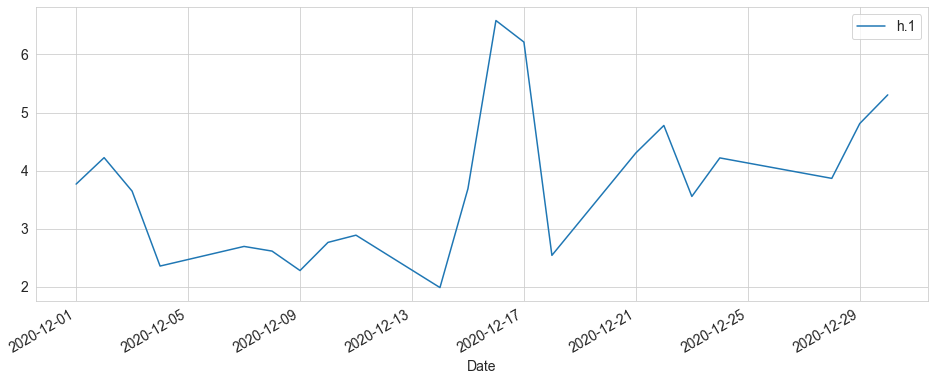

In [16]:
forecasts_aapl = garch_results.forecast(horizon=1, start=split_date, reindex=False)
forecasts_aapl.variance[split_date:].plot()

In [17]:
print(forecasts_aapl.variance)

                 h.1
Date                
2020-12-01  3.767673
2020-12-02  4.223029
2020-12-03  3.646521
2020-12-04  2.356134
2020-12-07  2.694157
2020-12-08  2.613787
2020-12-09  2.278870
2020-12-10  2.763616
2020-12-11  2.887756
2020-12-14  1.985468
2020-12-15  3.688712
2020-12-16  6.584885
2020-12-17  6.213856
2020-12-18  2.540437
2020-12-21  4.304239
2020-12-22  4.777231
2020-12-23  3.555111
2020-12-24  4.218758
2020-12-28  3.866102
2020-12-29  4.810851
2020-12-30  5.304322


# Simulation forecasts

<AxesSubplot:xlabel='Date'>

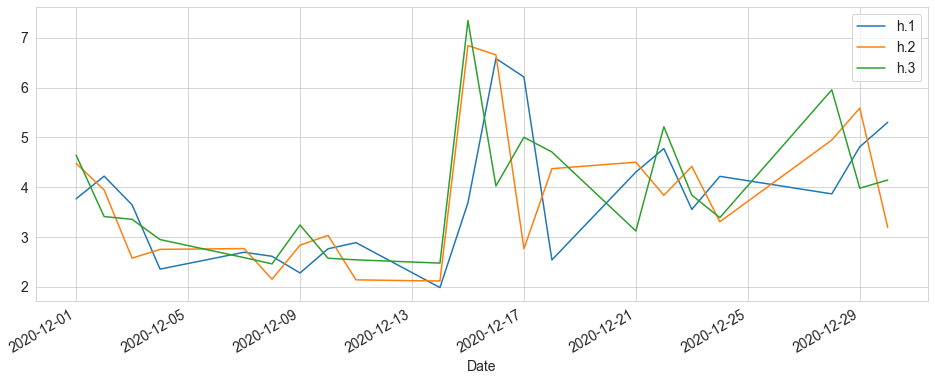

In [18]:
simu_forecasts_aapl = garch_results.forecast(horizon=3, start=split_date, method="simulation", reindex=False)
simu_forecasts_aapl.variance[split_date:].plot()

In [19]:
#computing realized volatility
realized_vol = returns.loc[(split_date-dt.timedelta(7)):,:].rolling(5).std()
realized_vol.dropna(axis=0, inplace=True)
realized_vol

,AAPL,FTNT,NVDA
Date,,,
2020-12-01,1.071712,1.546059,1.315293
2020-12-02,1.205457,1.561821,0.877836
2020-12-03,1.363003,1.784015,0.910939
2020-12-04,1.560452,1.327126,1.004080
2020-12-07,1.443685,1.217568,0.945995
2020-12-08,0.673017,1.250652,1.379764
2020-12-09,1.250043,3.107003,1.736402
2020-12-10,1.402737,2.979917,1.813284
2020-12-11,1.415931,2.930809,1.620284


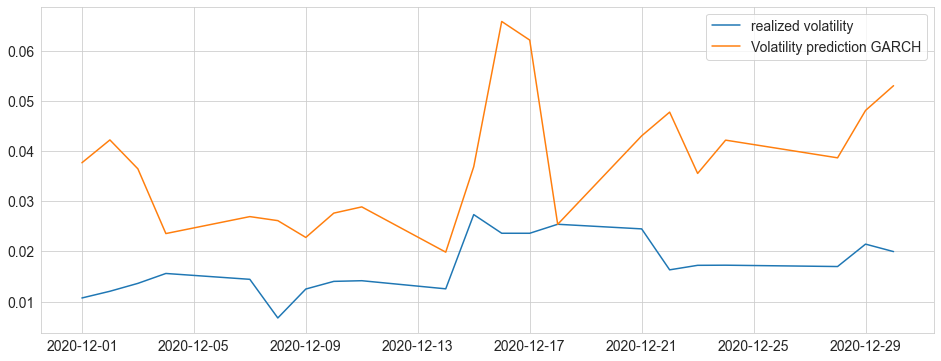

In [20]:
#plotting realized volatility vs volatility prediction with GARCH
plt.plot(realized_vol['AAPL'] /100, label="realized volatility")
plt.plot(forecasts_aapl.variance/100, label="Volatility prediction GARCH")
plt.legend()
plt.show()

# EGARCH

In [21]:
aic_egarch = []

for p in range(1, 11):
    for q in range(1, 11):
        egarch = arch_model(returns['AAPL'], mean='zero', vol='EGARCH', p=p, q=q)\
              .fit(disp='off')
        aic_egarch.append(egarch.aic)
        if egarch.aic == np.min(aic_egarch):
            best_param = (p, q)
print(best_param)

(3, 3)


In [22]:
model = arch_model(returns['AAPL'], mean='zero', vol='EGARCH',
                 p=best_param[0], q=best_param[1], dist="skewt")
egarch = model.fit(disp='off',last_obs=split_date)
print(egarch.summary())
forecasts_egarch = egarch.forecast(start=split_date, reindex=False)

                             Zero Mean - EGARCH Model Results                            
Dep. Variable:                              AAPL   R-squared:                       0.000
Mean Model:                            Zero Mean   Adj. R-squared:                  0.001
Vol Model:                                EGARCH   Log-Likelihood:               -1482.38
Distribution:      Standardized Skew Student's t   AIC:                           2982.75
Method:                       Maximum Likelihood   BIC:                           3024.13
                                                   No. Observations:                  733
Date:                           Tue, May 10 2022   Df Residuals:                      733
Time:                                   12:02:12   Df Model:                            0
                              Volatility Model                             
                 coef    std err          t      P>|t|     95.0% Conf. Int.
--------------------------------------

In [23]:
print(forecasts_egarch.variance)

                 h.1
Date                
2020-12-01  4.732259
2020-12-02  4.425871
2020-12-03  3.655220
2020-12-04  2.799518
2020-12-07  3.073852
2020-12-08  2.974704
2020-12-09  2.838068
2020-12-10  3.302762
2020-12-11  3.383445
2020-12-14  2.396681
2020-12-15  4.506202
2020-12-16  6.271376
2020-12-17  4.183780
2020-12-18  3.105464
2020-12-21  5.295339
2020-12-22  4.769666
2020-12-23  3.535927
2020-12-24  4.995733
2020-12-28  4.503789
2020-12-29  4.373659
2020-12-30  5.950553


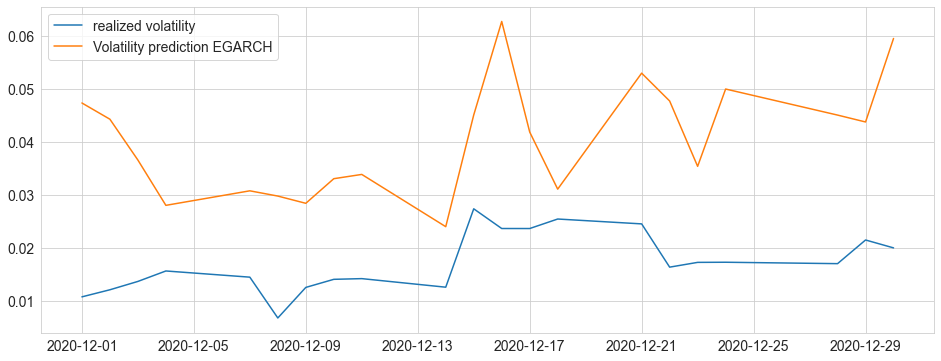

In [24]:
#plotting realized volatility vs volatility prediction with GARCH
plt.plot(realized_vol['AAPL'] /100, label="realized volatility")
plt.plot(forecasts_egarch.variance/100, label="Volatility prediction EGARCH")
plt.legend()
plt.show()

# SVM

In [25]:
realized_vol_aapl = returns['AAPL'].rolling(5).std()
realized_vol_aapl = pd.DataFrame(realized_vol_aapl)
realized_vol_aapl.reset_index(drop=True, inplace=True)
realized_vol_aapl

,AAPL
0,NaN
1,NaN
2,NaN
3,NaN
4,0.583326
...,...
749,1.722870
750,1.725328
751,1.698709
752,2.145510


In [26]:
returns_svm = returns['AAPL'] ** 2
returns_svm = returns_svm.reset_index()
del returns_svm['Date']
returns_svm

,AAPL
0,0.000302
1,0.215751
2,1.296226
3,0.137964
4,0.000132
...,...
749,0.486673
750,0.594798
751,12.791940
752,1.772893


In [27]:
X = pd.concat([realized_vol_aapl, returns_svm], axis=1, ignore_index=True)
X = X[4:].copy()
X = X.reset_index()
X.drop('index', axis=1, inplace=True)
X

,0,1
0,0.583326,0.000132
1,0.583944,0.000526
2,0.595638,0.322644
3,0.557252,1.066371
4,0.596668,0.258271
...,...,...
745,1.722870,0.486673
746,1.725328,0.594798
747,1.698709,12.791940
748,2.145510,1.772893


In [28]:
realized_vol = realized_vol.dropna().reset_index()
#realized_vol.drop('index', axis=1, inplace=True)

In [29]:
svr_poly = SVR(kernel='poly', degree=2)
svr_lin = SVR(kernel='linear')
svr_rbf = SVR(kernel='rbf')

In [30]:
realized_vol_aapl.dropna(axis=0, inplace=True)

In [31]:
n=21
para_grid = {'gamma': sp_rand(),
             'C': sp_rand(),
             'epsilon': sp_rand()}
clf = RandomizedSearchCV(svr_lin, para_grid)
clf.fit(X.iloc[:-n].values, realized_vol_aapl.iloc[1:-(n-1)].values.reshape(-1,))
predict_svr_lin = clf.predict(X.iloc[-n:])

In [32]:
predict_svr_lin = pd.DataFrame(predict_svr_lin)
predict_svr_lin.index = returns['AAPL'].iloc[-n:].index

In [33]:
predict_svr_lin

,0
Date,
2020-12-01,1.250244
2020-12-02,1.269051
2020-12-03,1.400646
2020-12-04,1.569481
2020-12-07,1.483233
2020-12-08,0.823581
2020-12-09,1.349040
2020-12-10,1.448164
2020-12-11,1.449476


In [34]:
realized_vol_aapl.index = returns['AAPL'].iloc[4:].index
realized_vol_aapl.index

DatetimeIndex(['2018-01-09', '2018-01-10', '2018-01-11', '2018-01-12',
               '2018-01-16', '2018-01-17', '2018-01-18', '2018-01-19',
               '2018-01-22', '2018-01-23',
               ...
               '2020-12-16', '2020-12-17', '2020-12-18', '2020-12-21',
               '2020-12-22', '2020-12-23', '2020-12-24', '2020-12-28',
               '2020-12-29', '2020-12-30'],
              dtype='datetime64[ns]', name='Date', length=750, freq=None)

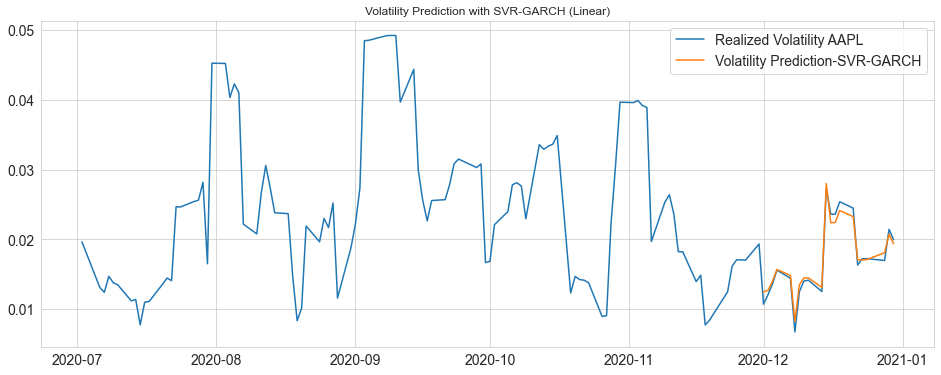

In [35]:
plt.plot(realized_vol_aapl[-126:] / 100, label='Realized Volatility AAPL')
plt.plot(predict_svr_lin / 100, label='Volatility Prediction-SVR-GARCH')
plt.title('Volatility Prediction with SVR-GARCH (Linear)', fontsize=12)
plt.legend()
plt.show()

# VaR with EGARCH forecasted variance

In [42]:
cond_mean = forecasts_egarch.mean['2020-12':]
cond_var = forecasts_egarch.variance['2020-12':]
q = model.distribution.ppf([0.01, 0.05], egarch.params[-2:])
print(q)

[-2.84334364 -1.62169448]


In [43]:
value_at_risk = -cond_mean.values - np.sqrt(cond_var).values * q[None, :]
value_at_risk = pd.DataFrame(value_at_risk, columns=['1%', '5%'], index=cond_var.index)
value_at_risk.describe()

,1%,5%
count,21.000000,21.000000
mean,5.675852,3.237209
std,0.750572,0.428087
min,4.401842,2.510581
25%,5.010633,2.857803
50%,5.815857,3.317061
75%,6.185341,3.527795
max,7.120505,4.061163


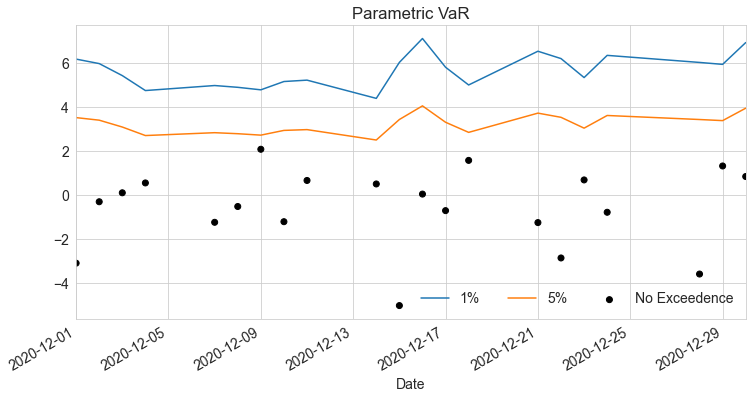

In [44]:
ax = value_at_risk.plot(legend=False, figsize=(12,6))
xl = ax.set_xlim(value_at_risk.index[0], value_at_risk.index[-1])

rets_2020 = returns.AAPL['2020-12':]
rets_2020.name = 'AAPL Returns'

c = []
for idx in value_at_risk.index:
    if rets_2020[idx] > -value_at_risk.loc[idx, '5%']:
        c.append('#000000')
    elif rets_2020[idx] < -value_at_risk.loc[idx, '1%']:
        c.append('#BB0000')
    else:
        c.append('#BB00BB')
        
c = np.array(c, dtype='object')

labels = {
    
    '#BB0000': '1% Exceedence',
    '#BB00BB': '5% Exceedence',
    '#000000': 'No Exceedence'
}

markers = {'#BB0000': 'x', '#BB00BB': 's', '#000000': 'o'}

for color in np.unique(c):
    sel = c == color
    ax.scatter(
        rets_2020.index[sel],
        -rets_2020.loc[sel],
        marker=markers[color],
        c=c[sel],
        label=labels[color])
    
ax.set_title('Parametric VaR')
ax.legend(frameon=False, ncol=3)

plt.show()